In [32]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import statsmodels.api as sm
from scipy.stats import levy_stable
import matplotlib.pyplot as plt
import time

## ========================== Parameter Declaration ========================== ##

time_delay = 2
filter_order = 5


## ============================== Define Function ============================= ##

# Additive White Gaussian Noise (AWGN)
def awgn(s, SNRdB, L = 1):
    gamma = 10 ** (SNRdB / 10) #SNR to linear scale
    if s.ndim == 1:# if s is single dimensional vector
        P = L * sum(abs(s) ** 2) / len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P = L * sum(sum(abs(s) ** 2)) / len(s) # if s is a matrix [MxN]
    N0 = P / gamma # Find the noise spectral density
    n = np.sqrt(N0/2) * np.random.standard_normal(s.shape) # computed noise
    r = s + n # received signal
    return r


## =========================== Generate Sampeles =========================== ##

# Generate input signal
mu = 0
sigma = 1
sample_size = 5001
input_signal_y = np.random.normal(mu, sigma, sample_size)

linear_filter_t = np.array([-0.8 * input_signal_y[i+1] + 0.7 * input_signal_y[i] for i in range(sample_size-1)])
nonlinear_filter_q = np.array([linear_filter_t[i] + 0.25 * linear_filter_t[i] ** 2 + 0.11 * linear_filter_t[i] ** 3 for i in range(len(linear_filter_t))])

signal_noise = awgn(nonlinear_filter_q, SNRdB = 15)

# Input and Output of Adaptive Filter
signal_x = nonlinear_filter_q + signal_noise
signal_x = signal_x/max(signal_x)
signal_y = input_signal_y[1:sample_size]
signal_y = signal_y/max(signal_y)

Text(0, 0.5, 'Filter Input')

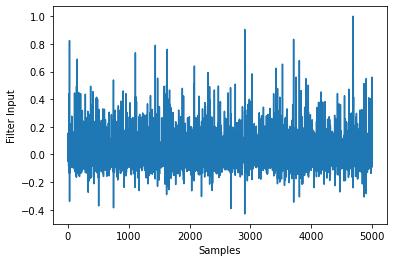

In [33]:
plt.plot(signal_x)
plt.xlabel('Samples')
plt.ylabel('Normalized filter input')

In [34]:
plt.plot(signal_y)
plt.xlabel('Samples')
plt.ylabel('Normalized desired response')

Text(0, 0.5, 'Filter Output')

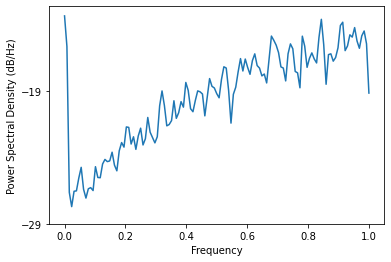

In [35]:
l1 = plt.psd(signal_x)
plt.grid(False)

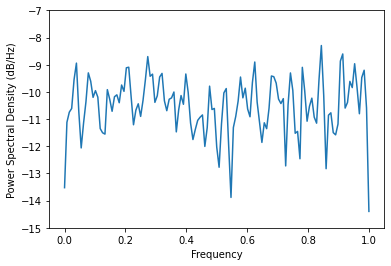

In [36]:
l2 = plt.psd(signal_y)
plt.grid(False)

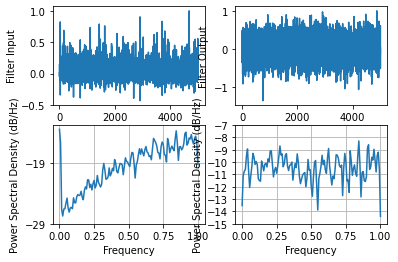

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
l1 = ax1.plot(signal_x)
plt.xlabel('Samples')
plt.ylabel('Filter Input')
ax2 = fig.add_subplot(2,2,2)
l2 = ax2.plot(signal_y)
plt.xlabel('Samples')
plt.ylabel('Filter Output')
ax3 = fig.add_subplot(2,2,3)
l3 = ax3.psd(signal_x)
ax4 = fig.add_subplot(2,2,4)
l4 = ax4.psd(signal_y)

In [71]:
# QKLMS With Kernel Size from 0.1, 0.4, 0.8

mu = 0.1 # step size
MSE_test_num = 100
sigma = np.array([0.1, 0.4, 0.8]) # kernel size
h_vector = 1 / (2 * sigma ** 2)
delta = 0.1 # quantization threshold

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order-time_delay:len(signal_x)-time_delay]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * sum((x1 - x2) ** 2))

for hhh in range(len(h_vector)):
    h = h_vector[hhh]
    QKLMS_center_list = []
    QKLMS_alpha_list = []
    QKLMS_network_size = [[], [], []]
    QKLMS_MSE_store = [[], [], []]
    QKLMS_dist_dis = []

    for i in range (len(filter_x) - MSE_test_num): # len(filter_x) - MSE_test_num
        if i == 0:
            filter_output = 0
            QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
            QKLMS_center_list.append(filter_x[i])
        else:
            filter_output = np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[i], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))]))
            dist_store = []
            for mm in range (len(QKLMS_center_list)):
                dist_store.append(np.linalg.norm(filter_x[i] - QKLMS_center_list[mm]))
            dist_min_index = np.argmin(np.array(dist_store))
            dist_min = min(dist_store)
            QKLMS_dist_dis.append(dist_min)
            if dist_min <= delta:
                QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (filter_y[i] - filter_output)
            else:
                QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
                QKLMS_center_list.append(filter_x[i])
        QKLMS_network_size[hhh].append(len(QKLMS_center_list))
        MSE_store = []
        for nn in range (i, i + MSE_test_num):
            MSE_store.append(filter_y[nn] - np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[nn], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))])))
        MSE_store = np.array(MSE_store)
        QKLMS_MSE_store[hhh].append(np.sum((MSE_store) ** 2)/len(MSE_store))
        print(i)
    
# error
l1 = plt.plot(np.arange(len(QKLMS_MSE_store[0])), QKLMS_MSE_store[0])
l2 = plt.plot(np.arange(len(QKLMS_MSE_store[1])), QKLMS_MSE_store[1])
l3 = plt.plot(np.arange(len(QKLMS_MSE_store[2])), QKLMS_MSE_store[2])
plt.legend(['𝜎 = 0.1', '𝜎 = 0.4', '𝜎 = 0.8'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582


2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304


3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943


638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887


2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553


3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195


D:\Software\Anaconda\Install\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 120590 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Software\Anaconda\Install\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 120590 missing from current font.
  font.set_text(s, 0, flags=flags)


In [72]:
# error
l1 = plt.plot(np.arange(len(QKLMS_MSE_store[0])), QKLMS_MSE_store[0])
l2 = plt.plot(np.arange(len(QKLMS_MSE_store[1])), QKLMS_MSE_store[1])
l3 = plt.plot(np.arange(len(QKLMS_MSE_store[2])), QKLMS_MSE_store[2])
plt.legend([r'$\sigma=0.1$', r'$\sigma=0.4$', r'$\sigma=0.8$'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585


2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307


3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946


642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891


2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556


3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198


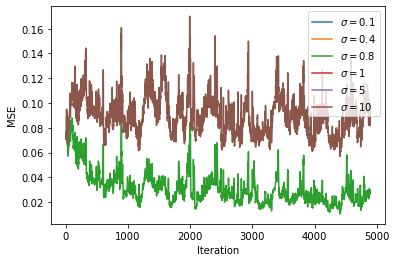

In [73]:
# QKLMS With Kernel Size from 0.1, 0.4, 0.8

mu = 0.1 # step size
MSE_test_num = 100
sigma = np.array([1, 5, 10]) # kernel size
h_vector = 1 / (2 * sigma ** 2)
delta = 0.1 # quantization threshold

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order-time_delay:len(signal_x)-time_delay]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * sum((x1 - x2) ** 2))

for hhh in range(len(h_vector)):
    h = h_vector[hhh]
    QKLMS_center_list = []
    QKLMS_alpha_list = []
    QKLMS_network_size1 = [[], [], []]
    QKLMS_MSE_store1 = [[], [], []]
    QKLMS_dist_dis = []

    for i in range (len(filter_x) - MSE_test_num): # len(filter_x) - MSE_test_num
        if i == 0:
            filter_output = 0
            QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
            QKLMS_center_list.append(filter_x[i])
        else:
            filter_output = np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[i], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))]))
            dist_store = []
            for mm in range (len(QKLMS_center_list)):
                dist_store.append(np.linalg.norm(filter_x[i] - QKLMS_center_list[mm]))
            dist_min_index = np.argmin(np.array(dist_store))
            dist_min = min(dist_store)
            QKLMS_dist_dis.append(dist_min)
            if dist_min <= delta:
                QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (filter_y[i] - filter_output)
            else:
                QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
                QKLMS_center_list.append(filter_x[i])
        QKLMS_network_size1[hhh].append(len(QKLMS_center_list))
        MSE_store = []
        for nn in range (i, i + MSE_test_num):
            MSE_store.append(filter_y[nn] - np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[nn], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))])))
        MSE_store = np.array(MSE_store)
        QKLMS_MSE_store1[hhh].append(np.sum((MSE_store) ** 2)/len(MSE_store))
        print(i)
    
# error
l1 = plt.plot(np.arange(len(QKLMS_MSE_store[0])), QKLMS_MSE_store[0])
l2 = plt.plot(np.arange(len(QKLMS_MSE_store[1])), QKLMS_MSE_store[1])
l3 = plt.plot(np.arange(len(QKLMS_MSE_store[2])), QKLMS_MSE_store[2])
l4 = plt.plot(np.arange(len(QKLMS_MSE_store1[0])), QKLMS_MSE_store1[0])
l5 = plt.plot(np.arange(len(QKLMS_MSE_store1[1])), QKLMS_MSE_store1[1])
l6 = plt.plot(np.arange(len(QKLMS_MSE_store1[2])), QKLMS_MSE_store1[2])
plt.legend([r'$\sigma=0.1$', r'$\sigma=0.4$', r'$\sigma=0.8$', r'$\sigma=1$', r'$\sigma=5$', r'$\sigma=10$'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

In [ ]:
# network size
l1 = plt.plot(np.arange(len(QKLMS_network_size[0])), QKLMS_network_size[0])
l2 = plt.plot(np.arange(len(QKLMS_network_size[1])), QKLMS_network_size[1])
l3 = plt.plot(np.arange(len(QKLMS_network_size[2])), QKLMS_network_size[2])
plt.legend(['𝜎 = 0.1', '𝜎 = 0.4', '𝜎 = 0.8'])
plt.xlabel('Iteration')
plt.ylabel('Network size')
plt.show()

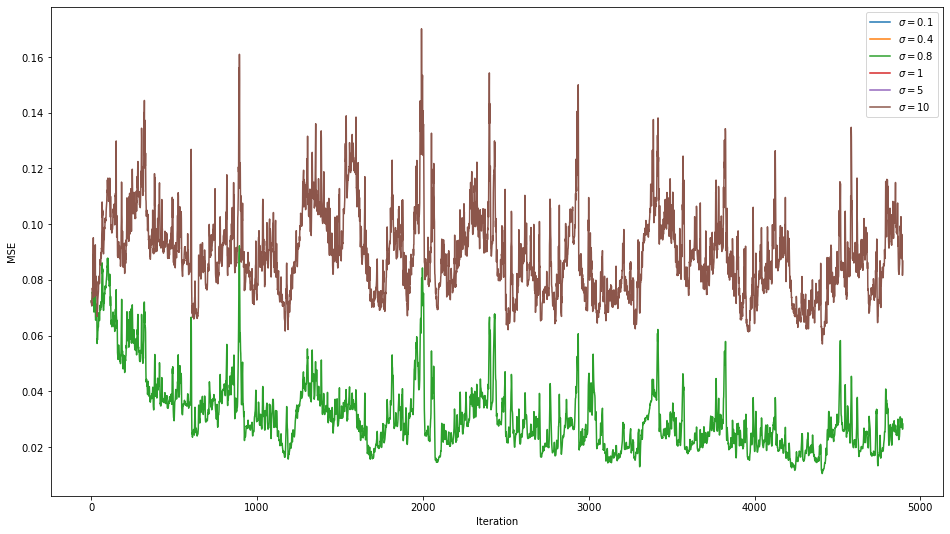

In [75]:
# Plots of effects of kernel size 
# error
fig = plt.figure(figsize = (16, 9))
l1 = plt.plot(np.arange(len(QKLMS_MSE_store[0])), QKLMS_MSE_store[0])
l2 = plt.plot(np.arange(len(QKLMS_MSE_store[1])), QKLMS_MSE_store[1])
l3 = plt.plot(np.arange(len(QKLMS_MSE_store[2])), QKLMS_MSE_store[2])
l4 = plt.plot(np.arange(len(QKLMS_MSE_store1[0])), QKLMS_MSE_store1[0])
l5 = plt.plot(np.arange(len(QKLMS_MSE_store1[1])), QKLMS_MSE_store1[1])
l6 = plt.plot(np.arange(len(QKLMS_MSE_store1[2])), QKLMS_MSE_store1[2])
plt.legend([r'$\sigma=0.1$', r'$\sigma=0.4$', r'$\sigma=0.8$', r'$\sigma=1$', r'$\sigma=5$', r'$\sigma=10$'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

The time of execution using LMS: 1.6457326412200928


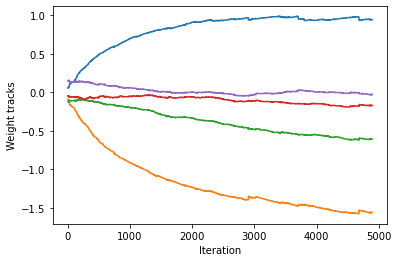

In [46]:
# LMS Algorithm

weight_filter = np.random.normal(0, 0.1, filter_order) # initialize weights 

mu = 0.05 # step size
MSE_test_num = 100

weight_LMS_store = []
error_LMS_store = []
LMS_MSE_store = []

LMS_start = time.time()

for n in range(filter_order, len(signal_x)-MSE_test_num):
    e_n = signal_y[n-time_delay] - np.dot(weight_filter, signal_x[n-filter_order:n][::-1])
    weight_filter = weight_filter + mu * signal_x[n-filter_order:n][::-1] * e_n
    weight_LMS_store.append(weight_filter)
    error_LMS_store.append(np.abs(e_n))
    MSE_store = []
    for i in range (n, n + MSE_test_num):
        MSE_store.append(signal_y[i-time_delay] - np.dot(weight_filter, signal_x[i-filter_order:i][::-1]))
    MSE_store = np.array(MSE_store)
    LMS_MSE_store.append(np.sum((MSE_store) ** 2)/len(MSE_store))

LMS_end = time.time()
print('The time of execution using LMS:', LMS_end - LMS_start)
    
# weight tracks
plt.plot(np.arange(len(weight_LMS_store)), weight_LMS_store)
plt.xlabel('Iteration')
plt.ylabel('Weight tracks')
plt.show()

In [47]:
# error
plt.plot(np.arange(len(LMS_MSE_store)), LMS_MSE_store)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

In [58]:
# KLMS Algorithm

mu = 0.1 # step size
MSE_test_num = 100
sigma = np.array([0.1, 0.4, 0.8]) # kernel size
h_vector = 1 / (2 * sigma ** 2)
h = 0.02 # parameter of Gaussian kernel

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order-time_delay:len(signal_x)-time_delay]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * sum((x1 - x2) ** 2))

# define KLMS
KLMS_center_list = []
KLMS_alpha_list = []
KLMS_network_size = []
KLMS_MSE_store = []

KLMS_start = time.time()

for i in range (len(filter_x) - MSE_test_num): #len(filter_x) - MSE_test_num
    if i == 0:
        filter_output = 0
    else:
        filter_output = np.sum(np.array([KLMS_alpha_list[j] * kernel(filter_x[i], KLMS_center_list[j], h) for j in range (len(KLMS_center_list))]))
    KLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
    KLMS_center_list.append(filter_x[i])
    KLMS_network_size.append(len(KLMS_center_list))
    MSE_store = []
    for nn in range (i, i + MSE_test_num):
        MSE_store.append(filter_y[nn] - np.sum(np.array([KLMS_alpha_list[j] * kernel(filter_x[nn], KLMS_center_list[j], h) for j in range (len(KLMS_center_list))])))
    MSE_store = np.array(MSE_store)
    KLMS_MSE_store.append(np.sum((MSE_store) ** 2)/len(MSE_store))
    print(i)

KLMS_end = time.time()
print('The time of execution using KLMS:', KLMS_end - KLMS_start)
    
# error
plt.plot(np.arange(len(KLMS_MSE_store)), KLMS_MSE_store)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


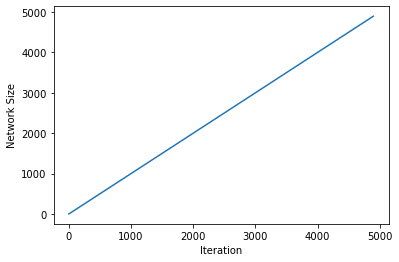

In [59]:
# Network size
plt.plot(np.arange(len(KLMS_network_size)), KLMS_network_size)
plt.xlabel('Iteration')
plt.ylabel('Network Size')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


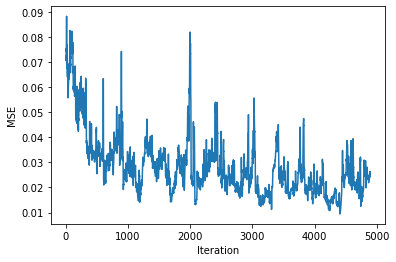

In [60]:
# KLMS-NC Algorithm

mu = 0.1 # step size
MSE_test_num = 100
sigma = np.array([0.1, 0.4, 0.8]) # kernel size
h_vector = 1 / (2 * sigma ** 2)
h = 0.02 # parameter of Gaussian kernel
delta_1 = 0.04 # NC threshold1
delta_2 = 0.04

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order-time_delay:len(signal_x)-time_delay]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * sum((x1 - x2) ** 2))

# define KLMS-NC
KLMS_NC_center_list = []
KLMS_NC_alpha_list = []
KLMS_NC_network_size = []
KLMS_NC_MSE_store = []
KLMS_NC_dist_dis = []

KLMS_NC_start = time.time()

for i in range (len(filter_x) - MSE_test_num): # len(filter_x) - MSE_test_num
    if i == 0:
        filter_output = 0
        KLMS_NC_alpha_list.append(mu * (filter_y[i] - filter_output))
        KLMS_NC_center_list.append(filter_x[i])
    else:
        filter_output = np.sum(np.array([KLMS_NC_alpha_list[j] * kernel(filter_x[i], KLMS_NC_center_list[j], h) for j in range (len(KLMS_NC_center_list))]))
        dist_store = []
        for mm in range (len(KLMS_NC_center_list)):
            dist_store.append(np.linalg.norm(filter_x[i] - KLMS_NC_center_list[mm]))
        dist_min = min(dist_store)
        KLMS_NC_dist_dis.append(dist_min)
        if dist_min > delta_1:
            if abs(filter_y[i] - filter_output) > delta_2:
                KLMS_NC_alpha_list.append(mu * (filter_y[i] - filter_output))
                KLMS_NC_center_list.append(filter_x[i])
    KLMS_NC_network_size.append(len(KLMS_NC_center_list))
    MSE_store = []
    for nn in range (i, i + MSE_test_num):
        MSE_store.append(filter_y[nn] - np.sum(np.array([KLMS_NC_alpha_list[j] * kernel(filter_x[nn], KLMS_NC_center_list[j], h) for j in range (len(KLMS_NC_center_list))])))
    MSE_store = np.array(MSE_store)
    KLMS_NC_MSE_store.append(np.sum((MSE_store) ** 2)/len(MSE_store))
    print(i)

KLMS_NC_end = time.time()
print('The time of execution using KLMS_NC:', KLMS_NC_end - KLMS_NC_start)
    
# error
plt.plot(np.arange(len(KLMS_NC_MSE_store)), KLMS_NC_MSE_store)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

In [61]:
# Network size
plt.plot(np.arange(len(KLMS_NC_network_size)), KLMS_NC_network_size)
plt.xlabel('Iteration')
plt.ylabel('Network Size')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


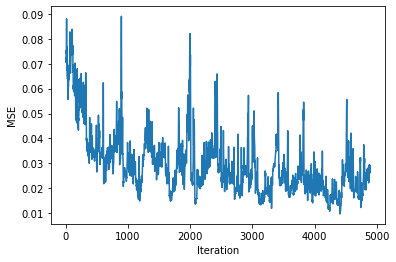

In [56]:
# QKLMS Algorithm

mu = 0.1 # step size
MSE_test_num = 100
sigma = np.array([0.1, 0.4, 0.8]) # kernel size
h_vector = 1 / (2 * sigma ** 2)
h = 0.02 # parameter of Gaussian kernel
delta = 0.1 # quantization threshold

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order-time_delay:len(signal_x)-time_delay]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * sum((x1 - x2) ** 2))

# define QKLMS
QKLMS_center_list = []
QKLMS_alpha_list = []
QKLMS_network_size = []
QKLMS_MSE_store = []
QKLMS_dist_dis = []

QKLMS_start = time.time()

for i in range (len(filter_x) - MSE_test_num): # len(filter_x) - MSE_test_num
    if i == 0:
        filter_output = 0
        QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
        QKLMS_center_list.append(filter_x[i])
    else:
        filter_output = np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[i], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))]))
        dist_store = []
        for mm in range (len(QKLMS_center_list)):
            dist_store.append(np.linalg.norm(filter_x[i] - QKLMS_center_list[mm]))
        dist_min_index = np.argmin(np.array(dist_store))
        dist_min = min(dist_store)
        QKLMS_dist_dis.append(dist_min)
        if dist_min <= delta:
            QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (filter_y[i] - filter_output)
        else:
            QKLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
            QKLMS_center_list.append(filter_x[i])
    QKLMS_network_size.append(len(QKLMS_center_list))
    MSE_store = []
    for nn in range (i, i + MSE_test_num):
        MSE_store.append(filter_y[nn] - np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[nn], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))])))
    MSE_store = np.array(MSE_store)
    QKLMS_MSE_store.append(np.sum((MSE_store) ** 2)/len(MSE_store))
    print(i)

QKLMS_end = time.time()
print('The time of execution using QKLMS:', QKLMS_end - QKLMS_start)
    
# error
plt.plot(np.arange(len(QKLMS_MSE_store)), QKLMS_MSE_store)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

In [57]:
# Network size
plt.plot(np.arange(len(QKLMS_network_size)), QKLMS_network_size)
plt.xlabel('Iteration')
plt.ylabel('Network Size')
plt.show()

In [ ]:
# Calculate MSE

# LMS

lms_mse_store = []
for kk in range (filter_order, len(signal_x)):
    lms_mse_store.append(signal_y[kk-time_delay] - np.dot(weight_LMS_store[-1], signal_x[kk-filter_order:kk][::-1]))
lms_mse_store = np.array(lms_mse_store)
LMS_MSE_FINAL = np.sum((lms_mse_store) ** 2)/len(lms_mse_store)
print("MSE of LMS Algorithm:", LMS_MSE_FINAL)

# KLMS series
h = 1
klms_mse_store = []
klms_nc_mse_store = []
qklms_mse_store = []
for kk in range (len(filter_y)):
    klms_mse_store.append(filter_y[kk] - np.sum(np.array([KLMS_alpha_list[j] * kernel(filter_x[kk], KLMS_center_list[j], h) for j in range (len(KLMS_center_list))])))
    klms_nc_mse_store.append(filter_y[kk] - np.sum(np.array([KLMS_NC_alpha_list[j] * kernel(filter_x[kk], KLMS_NC_center_list[j], h) for j in range (len(KLMS_NC_center_list))])))
    qklms_mse_store.append(filter_y[kk] - np.sum(np.array([QKLMS_alpha_list[j] * kernel(filter_x[kk], QKLMS_center_list[j], h) for j in range (len(QKLMS_center_list))])))
klms_mse_store = np.array(klms_mse_store)
klms_nc_mse_store = np.array(klms_nc_mse_store)
qklms_mse_store = np.array(qklms_mse_store)
KLMS_MSE_FINAL = np.sum((klms_mse_store) ** 2)/len(klms_mse_store)
KLMS_NC_MSE_FINAL = np.sum((klms_nc_mse_store) ** 2)/len(klms_nc_mse_store)
QKLMS_MSE_FINAL = np.sum((qklms_mse_store) ** 2)/len(qklms_mse_store)
print("MSE of KLMS Algorithm:", KLMS_MSE_FINAL)
print("MSE of KLMS-NC Algorithm:", KLMS_NC_MSE_FINAL)
print("MSE of QKLMS Algorithm:", QKLMS_MSE_FINAL)

In [ ]:
# Comparison of MSE by iteration
l1 = plt.plot(np.arange(len(LMS_MSE_store)), LMS_MSE_store)
l2 = plt.plot(np.arange(len(KLMS_MSE_store)), KLMS_MSE_store)
l3 = plt.plot(np.arange(len(KLMS_NC_MSE_store)), KLMS_NC_MSE_store)
l4 = plt.plot(np.arange(len(QKLMS_MSE_store)), QKLMS_MSE_store)
plt.legend(['LMS', 'KLMS', 'NC-KLMS', 'QKLMS'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Comparison of network size
l1 = plt.plot(np.arange(len(KLMS_network_size)), KLMS_network_size)
l2 = plt.plot(np.arange(len(KLMS_NC_network_size)), QKLMS_NC_network_size)
l3 = plt.plot(np.arange(len(QKLMS_network_size)), QKLMS_network_size)
plt.legend(['KLMS', 'NC-KLMS', 'QKLMS'])
plt.xlabel('Iteration')
plt.ylabel('Network Size')
plt.show()